In [ ]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 147MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 27.4MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 31.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.57MB/s]


In [ ]:
batch_size = 64

train_loader = DataLoader(
    dataset=mnist_trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
    dataset=mnist_testset, batch_size=batch_size, shuffle=False)

print("MNIST Train size:", len(train_loader.dataset))
print("MNIST Test size:", len(test_loader.dataset))

MNIST Train size: 60000
MNIST Test size: 10000


In [ ]:
class AE(nn.Module):
  def __init__(self, l_latent_space_size, last_function_activation = nn.Tanh()):
    super().__init__()
    layers_encode = []
    layers_decode = []
    current_size = 28*28

    # Encode
    for layer_size in l_latent_space_size[:-1]:
      layers_encode.append( nn.Linear(in_features=current_size, out_features=layer_size) )
      layers_encode.append( nn.ReLU() )
      current_size = layer_size
    layers_encode.append( nn.Linear(in_features=current_size, out_features=l_latent_space_size[-1]) ) # После последнего сжимающего слоя нет функции активации
    current_size = l_latent_space_size[-1]

    # Decode
    for layer_size in l_latent_space_size[::-1][1:]:
      layers_decode.append( nn.Linear(in_features=current_size, out_features=layer_size) )
      layers_decode.append( nn.ReLU() )
      current_size = layer_size
    layers_decode.append( nn.Linear(in_features=current_size, out_features=28*28) )
    layers_decode.append( last_function_activation )

    self.encoder = nn.Sequential(*layers_encode)
    self.decoder = nn.Sequential(*layers_decode)


  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

model_1 = AE([196, 49], nn.Tanh())
model_2 = AE([196, 49], nn.ReLU())
model_3 = AE([392, 196, 98, 49], nn.Tanh())
model_4 = AE([156, 32], nn.Tanh())

models = [model_1, model_2, model_3, model_4]

print(*models, sep='\n')

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=196, bias=True)
    (1): ReLU()
    (2): Linear(in_features=196, out_features=49, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=49, out_features=196, bias=True)
    (1): ReLU()
    (2): Linear(in_features=196, out_features=784, bias=True)
    (3): Tanh()
  )
)
AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=196, bias=True)
    (1): ReLU()
    (2): Linear(in_features=196, out_features=49, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=49, out_features=196, bias=True)
    (1): ReLU()
    (2): Linear(in_features=196, out_features=784, bias=True)
    (3): ReLU()
  )
)
AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=98, bias=True)
    (5): ReLU()
    (6): Linear(in_fea

In [ ]:
criterion = nn.MSELoss()
optimizers = []
for model in models:
  optimizers.append(optim.Adam(model.parameters(), lr=0.001))

def training_AE(model, criterion, optimizer, num_epochs, train_losses):
  for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
      images, _ = data
      images = images.view(-1, 28*28)

      outputs = model(images)
      loss = criterion(outputs, images)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

In [ ]:
num_epochs = 20
train_losses_for_all_model = []
times = []

for i in range(len(models)):
  train_losses = []

  time_start = time.time()
  training_AE(models[i], criterion, optimizers[i], num_epochs, train_losses)
  time_end = time.time()

  time_elapsed = time_end - time_start
  times.append(time_elapsed)
  train_losses_for_all_model.append(train_losses)
  print(f"Time elapsed: {time_elapsed:.1f} сек")

Epoch [1/20], Loss: 0.0857
Epoch [2/20], Loss: 0.0369
Epoch [3/20], Loss: 0.0295
Epoch [4/20], Loss: 0.0262
Epoch [5/20], Loss: 0.0239
Epoch [6/20], Loss: 0.0222
Epoch [7/20], Loss: 0.0210
Epoch [8/20], Loss: 0.0202
Epoch [9/20], Loss: 0.0195
Epoch [10/20], Loss: 0.0190
Epoch [11/20], Loss: 0.0185
Epoch [12/20], Loss: 0.0180
Epoch [13/20], Loss: 0.0178
Epoch [14/20], Loss: 0.0175
Epoch [15/20], Loss: 0.0172
Epoch [16/20], Loss: 0.0169
Epoch [17/20], Loss: 0.0168
Epoch [18/20], Loss: 0.0166
Epoch [19/20], Loss: 0.0164
Epoch [20/20], Loss: 0.0163
Time elapsed: 397.1 сек
Epoch [1/20], Loss: 0.9009
Epoch [2/20], Loss: 0.8924
Epoch [3/20], Loss: 0.8899
Epoch [4/20], Loss: 0.8892
Epoch [5/20], Loss: 0.8889
Epoch [6/20], Loss: 0.8887
Epoch [7/20], Loss: 0.8884
Epoch [8/20], Loss: 0.8879
Epoch [9/20], Loss: 0.8875
Epoch [10/20], Loss: 0.8872
Epoch [11/20], Loss: 0.8869
Epoch [12/20], Loss: 0.8868
Epoch [13/20], Loss: 0.8868
Epoch [14/20], Loss: 0.8867
Epoch [15/20], Loss: 0.8867
Epoch [16/20],

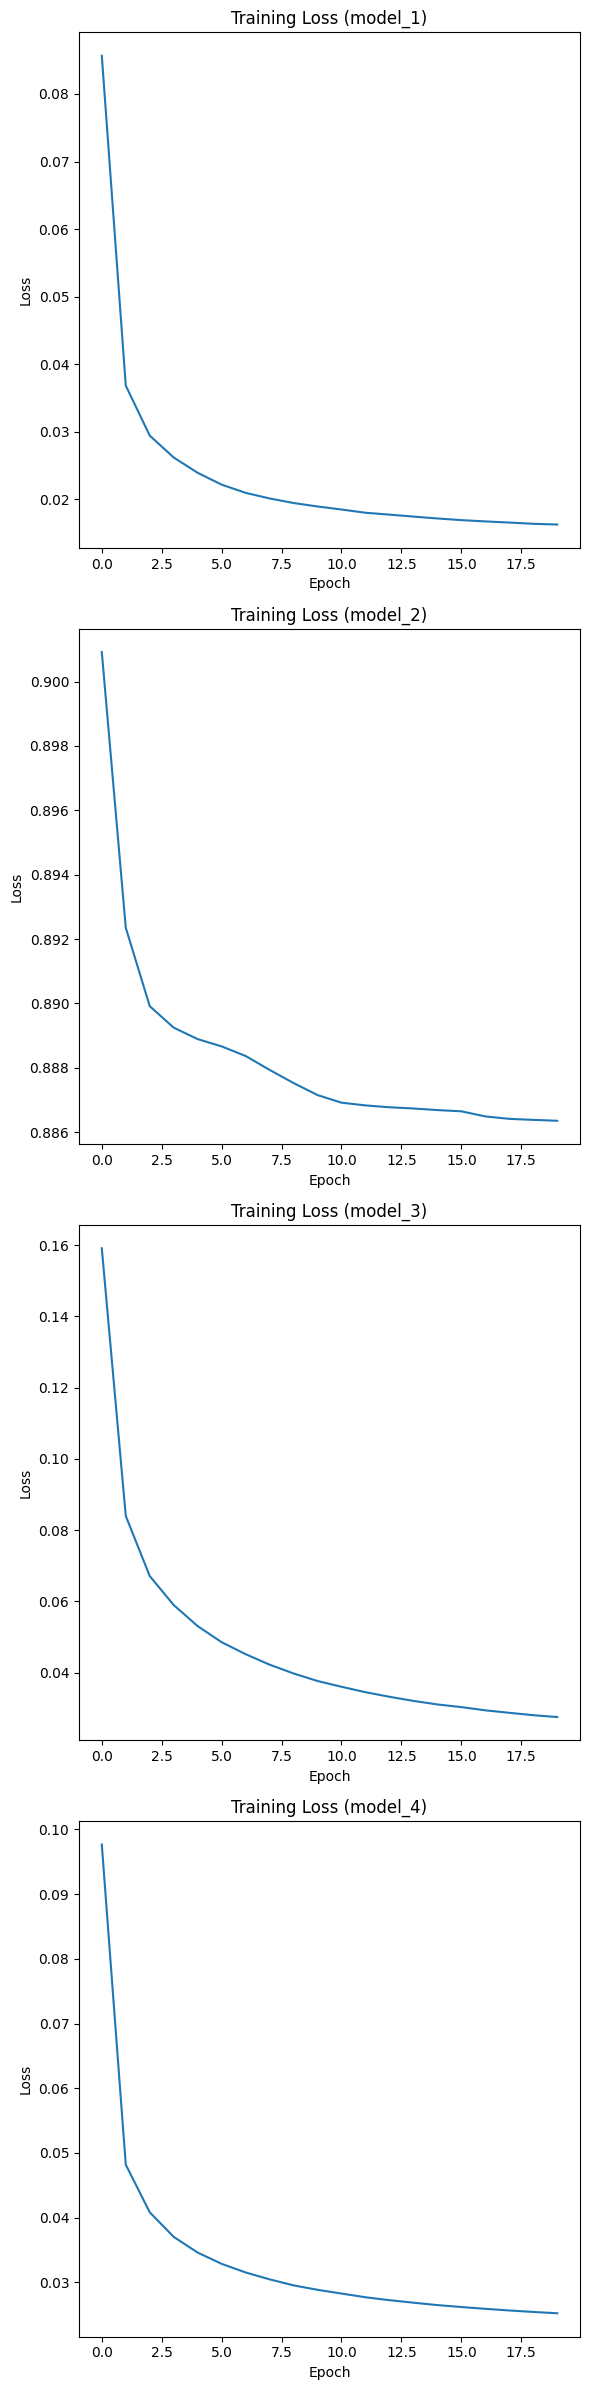

In [ ]:
for i in range(len(models)):
  plt.subplot(len(models), 1, i+1)
  plt.plot(train_losses_for_all_model[i])
  plt.title(f'Training Loss (model_{i+1})')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.tight_layout()
  plt.gcf().set_size_inches(6, 24)
plt.savefig("models.png")
plt.show()

outputs = []

with torch.no_grad():
  for i in range(len(models)):
    outputs.append([])
    for data in test_loader:
      images, _ = data
      images = images.view(-1, 28*28)
      outputs[i] = models[i](images)
      break

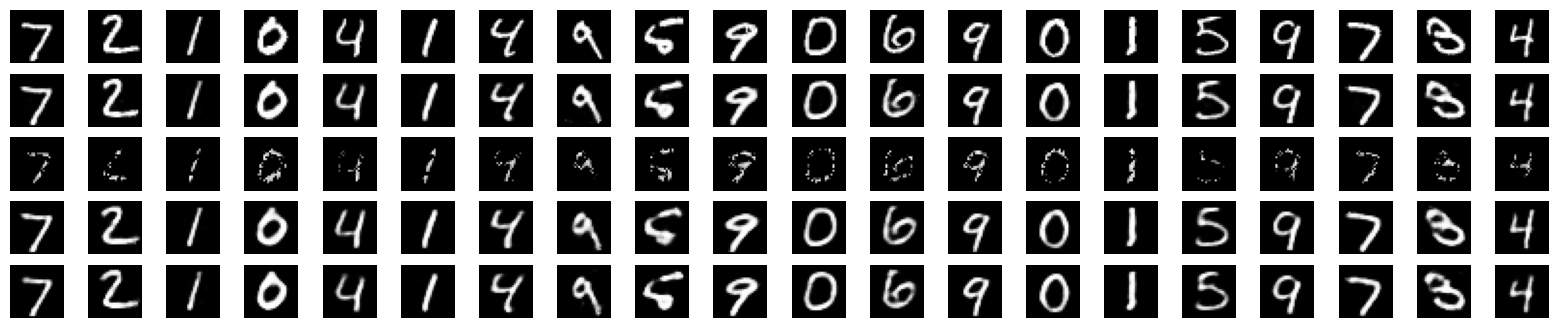

In [ ]:
num_images = 20

def imshow(img):
  img.cpu().numpy()
  plt.imshow(img.reshape(28, 28), cmap='gray')
  plt.axis('off')

plt.figure(figsize=(20, 4))
sub_size = 1+len(models)
for i in range(num_images):
  ax = plt.subplot(sub_size, num_images, i+1)
  imshow(images[i])
  for j in range(len(models)):
    ax = plt.subplot(sub_size, num_images, i+1 + (j+1)*num_images)
    imshow(outputs[j][i])

plt.savefig("results")
plt.show()

In [ ]:
torch.save(models[0], 'model_1.pth')